# <center>  <font style="color:rgb(100,109,254)">Text Detection With East Text Detector</font> </center>

In this notebook you'll learn to use a deep learning based text detector called **EAST TEXT DETECTOR** its based on the paper [EAST: An Efficient and Accurate Scene Text Detector](https://arxiv.org/pdf/1704.03155v2.pdf)

You should understand that we are doing text detection not text recognition. In text detection we simply detect areas in image containing text, in text recognition we pass in a cropped area of the image containing text to the algorithm and out comes the actual text in alphabets that the image contained.

A normal OCR (Optical character recognition) pipelines used in document scanner etc perform both text detection & text recognition.

After we have detected the text you can use [this python library](https://pypi.org/project/pytesseract/) to perform text recognition on it.

##  <font style="color:rgb(134,19,348)">Import Libraries</font> 


In [1]:
# Import Required libraries
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from tkinter import filedialog
from tkinter import Tk
import math
import os
%matplotlib inline

## <font style="color:rgb(134,19,348)"> Initialize the DNN module </font>

In [2]:
model = "Media/M4/Model/frozen_east_text_detection.pb"
net = cv2.dnn.readNet(model)

##  <font style="color:rgb(134,19,348)">Read Image</font> 


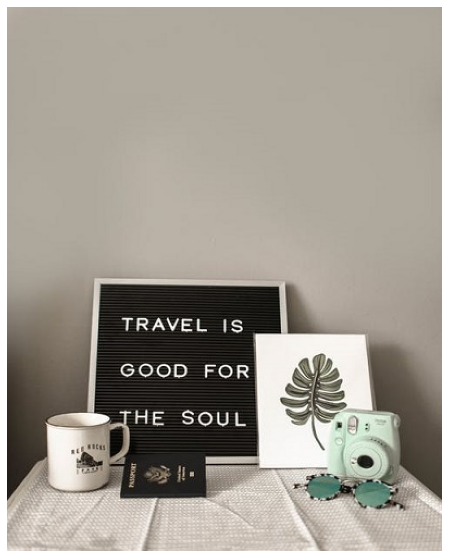

In [3]:
# Read image
image = cv2.imread("Media/M4/6.jpeg")

# Display image
plt.figure(figsize=[10,10])
plt.imshow(image[:,:,::-1])
plt.axis('off');

In [4]:
height, width = image.shape[:2]
height,width

(500, 400)

##  <font style="color:rgb(134,19,348)"> Pre-processing the image 
</font>

In [5]:
# Prepare the frame to be fed to the network
inpBlob  = cv2.dnn.blobFromImage(image, 1.0, (320, 320),(123.68, 116.78, 103.94), swapRB=True, crop=False)

##  <font style="color:rgb(134,19,348)">Forward Pass</font> 


In [6]:
%%time
net.setInput(inpBlob)

output = net.forward(["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"])

Wall time: 658 ms


In [7]:
# Fetch predicted scores
scores = output[0]
print(scores.shape)

# Geometry of the text box
geometry_box = output[1]
print(geometry_box.shape)

(1, 1, 80, 80)
(1, 5, 80, 80)


##  <font style="color:rgb(134,19,348)">Define function for Decoding</font> 


Decode function taken from [OpenCV Text Detection Implimentation](https://github.com/opencv/opencv/blob/master/samples/dnn/text_detection.py)

In [8]:
def decode(scores, geometry, scoreThresh):
    # Define detection detection and confidence variable
    detections = []
    confidences = []
    
    # Extracting height and width
    height = scores.shape[2]
    width = scores.shape[3]
    
    # Iterate all over height inorder to get x,y coordinates
    for y in range(0, height):
        
        # Extract data from scores
        scoresData = scores[0][0][y]
        x0_data = geometry[0][0][y]
        x1_data = geometry[0][1][y]
        x2_data = geometry[0][2][y]
        x3_data = geometry[0][3][y]
        anglesData = geometry[0][4][y]
        
        # Now itertate all over the width inorder to get the confidence score
        for x in range(0, width):
            
            # Extract confience
            score = scoresData[x]
            
            # If score is lower than threshold score, move to next x
            if(score < scoreThresh):
                continue
                
            # Calculate offset
            offsetX = x * 4.0
            offsetY = y * 4.0
            angle = anglesData[x]

            # Calculate cos and sin of angle
            cosA = math.cos(angle)
            sinA = math.sin(angle)
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]

            # Calculate offset
            offset = ([offsetX + cosA * x1_data[x] + sinA * x2_data[x], offsetY - sinA * x1_data[x] + cosA * x2_data[x]])

            # Find points for rectangle
            p1 = (-sinA * h + offset[0], -cosA * h + offset[1])
            p3 = (-cosA * w + offset[0],  sinA * w + offset[1])
            center = (0.5*(p1[0]+p3[0]), 0.5*(p1[1]+p3[1]))
            detections.append((center, (w,h), -1*angle * 180.0 / math.pi))
            confidences.append(float(score))

    # Return detections and confidences
    return [detections, confidences]

##  <font style="color:rgb(134,19,348)">Fetech Boxes and Scores</font> 


In [9]:
rects, conf = decode(scores, geometry_box, 0.5)

##  <font style="color:rgb(134,19,348)">Fetech non- duplicate boxes</font> 


In [10]:
indices = cv2.dnn.NMSBoxesRotated(rects, conf, 0.5, 0.3)

Fortunately In OpenCV you have a function called **cv2.dnn.NMSBoxesRotated** which takes care of all the pre-processing for you.

 [```cv2.dnn.NMSBoxesRotated(bboxes, scores, score_threshold, nms_threshold[, eta[, top_k]])```]( https://docs.opencv.org/3.4/d6/d0f/group__dnn.html#ga9d118d70a1659af729d01b10233213ee)

**Params:**

- **`bboxes`**  Take the bounding box of detection.
- **`scores`**  confidence scores for those bounding boxes.
- **`score_threshold`**  Take float value as input for score threshold. 
- **`nms_threshold`** Take float input threshold for NMS( Non Maximum Threshold ) for duplication of bounding boxes
So After this function we get indices of non duplicate boxes.

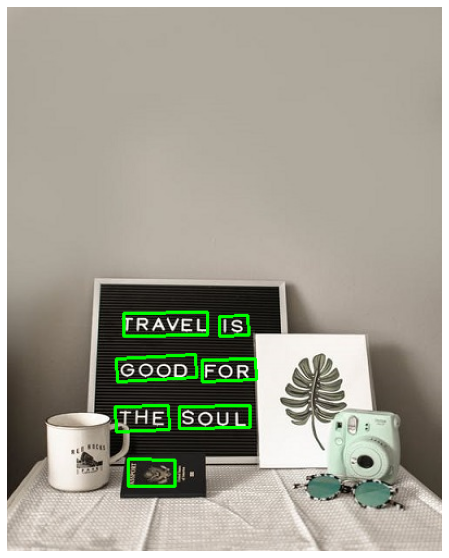

In [11]:
for i in indices:
            # get 4 corners of the rotated rect
            vertices = cv2.boxPoints(rects[i[0]])
            # scale the bounding box coordinates based on the respective ratios
            for j in range(4):
                vertices[j][0] *= width / float(320)
                vertices[j][1] *= height / float(320)
            for j in range(4):
                p1 = (vertices[j][0], vertices[j][1])
                p2 = (vertices[(j + 1) % 4][0], vertices[(j + 1) % 4][1])
                cv2.line(image, p1, p2, (0, 255, 0), 2)
plt.figure(figsize=(10,10))
plt.imshow(image[:,:,::-1]);plt.axis("off");                

## <font style="color:rgb(134,19,348)"> Creating Functions </font> 

## <font style="color:rgb(134,19,348)"> Initialization Function </font>

In [12]:
def init_textdetection(usegpu = 'None',model="frozen_east_text_detection.pb"):
    
    # Set global variables
    global net
    base_path = 'Media/M4/Model'
    
    # Defining model path
    model = os.path.join(base_path, model)    
    
    # Initialize the DNN module
    net = cv2.dnn.readNet(model)

    # If specified use either cuda based Nvidia gpu or opencl based Intel gpu.   
    if usegpu == 'cuda':
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
        
    elif usegpu == 'opencl':
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_OPENCL)    

## <font style="color:rgb(134,19,348)">  Main Method </font>

In [13]:
def textdetection(image=[], usercam=False,returndata=False,confidence = 0.5,nms_threshold=0.3):
    
    # If the user did'nt specified the image then consider then consider choosing file or camera snapshot.
    if np.size(image) == 0:
        
        # If usercam cam is True then take picture from camera
        if usercam:
            cap=cv2.VideoCapture(0, cv2.CAP_DSHOW)
            ret, frame = cap.read()
            if ret:
                image= cv2.flip(frame,1)
                cap.release()
            else:
                print('Cant Open Camera')
                sys.exit()
                
        # Otherwise select image from computer using tkinter        
        else:
            root = Tk()
            root.filename =  filedialog.askopenfilename(title = "Pick up the Image")
            root.withdraw()
            image = cv2.imread(root.filename)
            
    height, width = image.shape[:2]

    # Prepare the frame to be fed to the network
    inpBlob  = cv2.dnn.blobFromImage(image, 1.0, (320, 320),(123.68, 116.78, 103.94), swapRB=True, crop=False)   

    net.setInput(inpBlob)
    output = net.forward(["feature_fusion/Conv_7/Sigmoid","feature_fusion/concat_3"])

    # Fetch predicted scores
    scores = output[0]

    # Geometry of the text box
    geometry_box = output[1]

    # Fetch boxes and scores
    rects, conf = decode(scores, geometry_box, confidence)

    # Remove duplicate boxes
    indices = cv2.dnn.NMSBoxesRotated(rects, conf, confidence, nms_threshold)

    for i in indices:
        
        # get 4 corners of the rotated rect
        vertices = cv2.boxPoints(rects[i[0]])
        # scale the bounding box coordinates based on the respective ratios
        for j in range(4):
            vertices[j][0] *= width / float(320)
            vertices[j][1] *= height / float(320)
        for j in range(4):
            p1 = (vertices[j][0], vertices[j][1])
            p2 = (vertices[(j + 1) % 4][0], vertices[(j + 1) % 4][1])
            cv2.line(image, p1, p2, (0, 255, 0), 4)


    if  returndata:
        return image
    else:
        plt.figure(figsize=(10,10))
        plt.imshow(image[:,:,::-1]);plt.axis("off");          

**Initialize and Calling text detector with default arguments.**

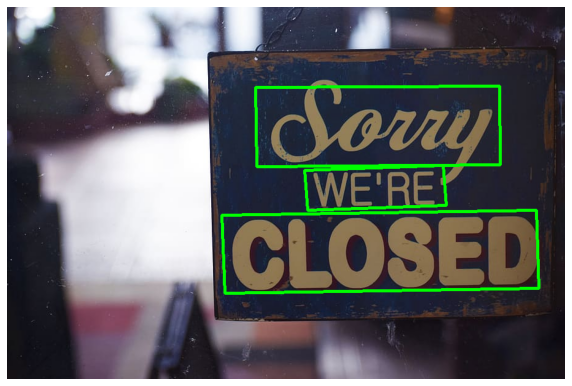

In [14]:
init_textdetection()
image = cv2.imread("Media/M4/txt3.jpg")
textdetection(image)

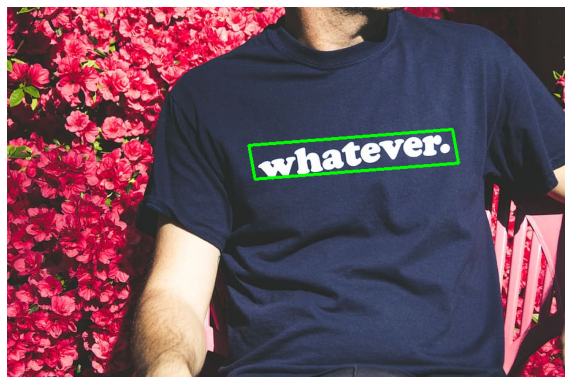

In [15]:
init_textdetection()
image = cv2.imread("Media/M4/txt6.jpg")
textdetection(image)

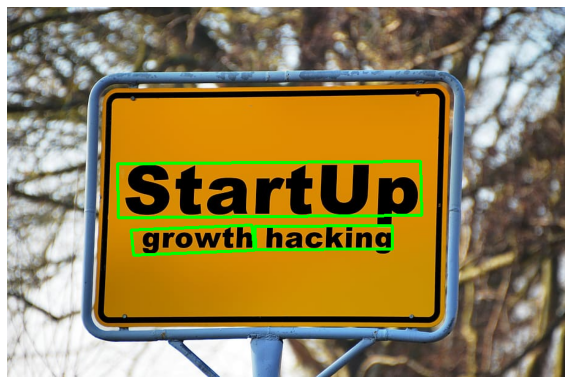

In [16]:
init_textdetection()
image = cv2.imread("Media/M4/txt4.jpg")
textdetection(image)

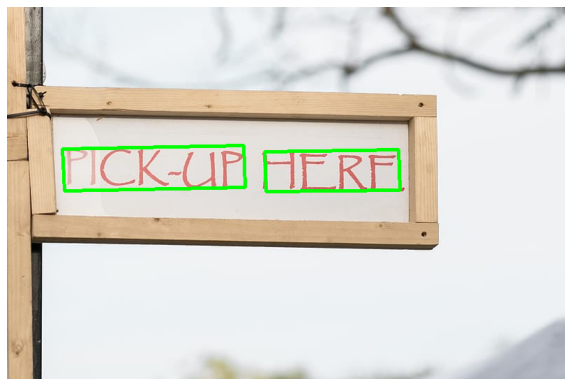

In [17]:
init_textdetection()
image = cv2.imread("Media/M4/txt5.jpg")
textdetection(image)

####  Capturing Text Image from Camera

In [ ]:
textdetection(usercam=True)

## <font style="color:rgb(134,19,348)"> Using Intel & Nvidia GPUs </font>

**CPU Time**

In [19]:
init_textdetection()

In [20]:
%%time
image= textdetection(image = image, returndata=True)

Wall time: 616 ms


**Intel GPU**

In [21]:
init_textdetection(usegpu = 'opencl')

In [22]:
%%time
image= textdetection(image = image, returndata=True)

Wall time: 22.1 s


**NVIDIA GPU**

In [23]:
init_textdetection(usegpu = 'cuda')

In [24]:
%%time
image= textdetection(image = image, returndata=True)

Wall time: 573 ms


## <font style="color:rgb(134,19,348)"> Real time Text Detection </font>

In [25]:
fps=0
init_textdetection()
cap=cv2.VideoCapture(0)

while(True):    
    start_time = time.time()
    ret,frame=cap.read() 
    image=cv2.flip(frame,1)
    
    image = textdetection(image,returndata=True)
    
    cv2.putText(image, 'FPS: {:.2f}'.format(fps), (400, 20), cv2.FONT_HERSHEY_SIMPLEX,0.8, (255, 20, 55), 2)
    cv2.imshow("Text Detection",image)
    
    k = cv2.waitKey(1)
    fps= (1.0 / (time.time() - start_time))
    
    if k == ord('q'):
        break
cap.release() 
cv2.destroyAllWindows() 